# Import libs

In [43]:
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [44]:
np.random.seed(10)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,5]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

In [46]:
project_location = "./"
# project_location = "e:/projects/stloc/"

# Load data

In [47]:
running_data = None
running_data = '2celltypes'

## Spatial data

In [48]:
if running_data != '2celltypes':
    df_st = pd.read_csv(project_location + "data/merfish/merfishSpatial.csv", sep=" ")
else:
    df_st = pd.read_csv(project_location + "data/twoType/spatialData/" + "Astrocyte"+"Inhibitory" + "Spatial.csv", sep=",")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
df_st.head()

,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf,Astrocyte,Inhibitory
0,0.0,0.0,24.042835,7.490070,0.000000,43.764002,0.0,7.061948,0.000000,0.0,...,0.00000,0.0,0.000000,0.016809,0.566421,0.000000,0.009827,0.018258,1.0,1.0
1,0.0,0.0,18.998619,18.594585,0.630872,40.359521,0.0,3.154416,1.261778,0.0,...,0.06346,0.0,0.072791,0.000000,0.562883,0.000000,0.003225,0.018325,1.0,1.0
2,0.0,0.0,20.779869,12.360754,0.000000,41.509898,0.0,3.562470,0.000000,0.0,...,0.00000,0.0,0.048410,0.000000,0.521170,0.000000,0.003225,0.008280,1.0,1.0
3,0.0,0.0,18.998619,3.454716,0.000000,39.728649,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.000000,0.000000,0.541505,0.014588,0.019870,0.000000,1.0,1.0
4,0.0,0.0,26.470893,3.454716,0.000000,57.875616,0.0,1.067474,0.533734,0.0,...,0.00000,0.0,0.000000,0.000000,0.510875,0.004664,0.024305,0.000000,1.0,1.0


In [49]:
reference = pd.read_csv(project_location + "data/merfish/markerGene_for_merfish_data.csv")
reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


In [50]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
if running_data == '2celltypes':
    celltypes = df_st.columns[-2:]
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount']).astype(int)
typeCountDf = df_st[celltypes].astype(int)
typeCountDf

,Astrocyte,Inhibitory
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
246,4,4
247,4,4
248,4,4
249,4,4


In [51]:
print(cellcount)
zero = (cellcount==0).sum()
print('zero count is',zero)
len(celltypes)

     cellcount
0            2
1            2
2            2
3            2
4            2
..         ...
246          8
247          8
248          8
249          8
250         10

[251 rows x 1 columns]
zero count is cellcount    0
dtype: int64


2

## Single-cell data

In [78]:
if running_data != '2celltypes':
    df_sc = pd.read_csv(project_location + "data/merfish/merfishVisium.csv")
else:
    df_sc = pd.read_csv(project_location + "data/twoType/singleCell/" + celltypes[0] + celltypes[1] + "Single.csv")
df_sc.head(2)

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID,Ace2,...,Penk,Scg2,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.273327,0.0,0.003225,0.0
1,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.273327,0.0,0.003225,0.0


In [79]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
2,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
3,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
4,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN


In [83]:
cellTypeColumn = df_sc["Cell_class"].to_numpy()
assert set(np.unique(cellTypeColumn)) == set(celltypes), "cellTypeColumn contains unknown celltype"

# Tangram

In [84]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(1260, 155)
(251, 155)


In [85]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [86]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:139 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:139 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [87]:
# adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

In [88]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf = adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 139 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.830, KL reg: 0.057
Score: 0.999, KL reg: 0.000
Score: 0.999, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000


INFO:root:Saving results..


In [89]:
probabilityDf.shape
# probabilityDf.head()
print(cellcount.head())
print(type(cellcount.iloc[2,0]))
cellcount.iloc[1,0]

   cellcount
0          2
1          2
2          2
3          2
4          2
<class 'numpy.int32'>


2

# Probability analysis

In [91]:
Nrows = len(df_st)
Ncols = len(celltypes)
print(Nrows, Ncols)
probabilityDf["Cell_class"]=cellTypeColumn
# print(probabilityDf["Cell_class"])

df_prediction = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
tempDf = probabilityDf.copy()

for i in range(Nrows):
    tempDf = tempDf.sort_values(by=[str(i)], ascending=False)
    
    for  j in range(cellcount.iloc[i,0]):
        cellClass = tempDf.iloc[j]["Cell_class"]
        df_prediction.iloc[i][cellClass]+=1

df_prediction = df_prediction.astype(int)
deconvolveDf = df_prediction.copy()
df_prediction.head()

251 2


,Astrocyte,Inhibitory
0,1,1
1,1,1
2,2,0
3,2,0
4,1,1


In [92]:
for i in range(len(df_prediction)):
    deconvolveDf.iloc[i] = 100 * df_prediction.iloc[i]/df_prediction.iloc[i].sum()

In [93]:
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)

Astrocyte     0
Inhibitory    0
dtype: int64

# Spatial data exploration

In [94]:
cnt_ = 0
for j in range(deconvolveDf.shape[1]):
    for i in range(deconvolveDf.shape[0]):
        # if celltype-specific cellcount is zero and deconvolution percentage > threshold
        if typeCountDf.iloc[i,j] == 0 and deconvolveDf.iloc[i,j] > 25:
            print(cellcount.iloc[i][0], deconvolveDf.columns[j], deconvolveDf.iloc[i,j])
            cnt_ += 1
            if cnt_ > 10:
                break

In [95]:
cellcount.value_counts()

cellcount
4            100
6            100
2             25
8             25
10             1
dtype: int64

# TANGRAM mispredictions

In [96]:
l = np.max(cellcount.values) + 1
count_misprediction = dict.fromkeys(celltypes)
for i in count_misprediction:
    count_misprediction[i] = dict.fromkeys(range(l))
    for j in count_misprediction[i]:
        count_misprediction[i][j] = [0, 0, dict.fromkeys(celltypes,0)]

for j in range(df_prediction.shape[1]):
    for i in range(df_prediction.shape[0]):
        actual_count = typeCountDf.iloc[i,j]
        predicted_count = df_prediction.iloc[i,j]
        tarr = count_misprediction[df_prediction.columns[j]][typeCountDf.iloc[i,j]]
        tarr[0] += 1
        if typeCountDf.iloc[i,j] != df_prediction.iloc[i,j]:
            tarr[1] += 1
            tarr[2] = {k: tarr[2].get(k, 0) + typeCountDf.iloc[i,:].to_dict().get(k, 0) \
                       for k in tarr[2].keys() | typeCountDf.iloc[i,:].to_dict().keys()}

Plotting for each celltype the number of spots with mispredictions

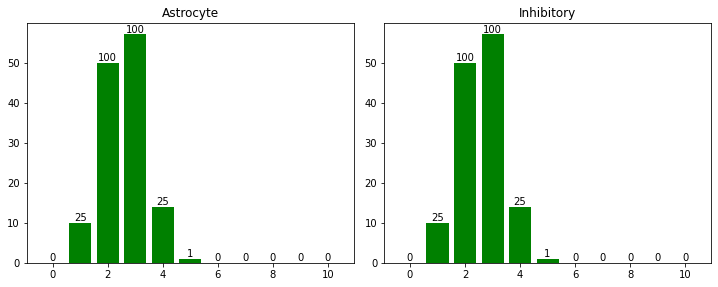

In [97]:
plt.rcParams['figure.figsize'] = [20,15]

for i, celltype in enumerate(celltypes):
    x = list(count_misprediction[celltype].keys())
    y = np.array(list(count_misprediction[celltype].values()))
    plt.subplot(4, 4, i+1)
    bar = plt.bar(x, y[:,1], width=0.8, color='g')
    for j, rect in enumerate(bar):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{y[j,0]:.0f}', ha='center', va='bottom')
    plt.title(celltype)
    plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

Plotting for each celltype the percentage of spots with mispredictions

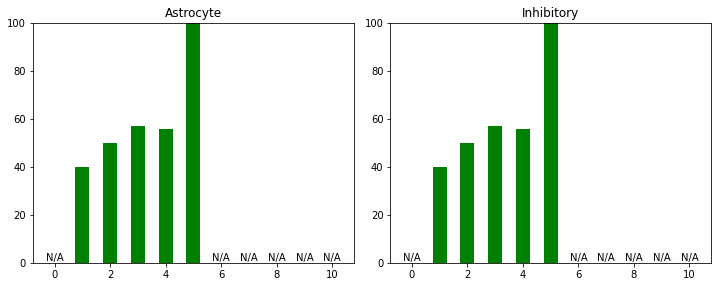

In [98]:
plt.rcParams['figure.figsize'] = [20,15]

for i, celltype in enumerate(celltypes):
    x = list(count_misprediction[celltype].keys())
    _y = np.array(list(count_misprediction[celltype].values()))[:,:2].astype(int)
    y = np.nan_to_num((_y[:,1] / _y[:,0]) * 100)
    # y = _y[:,1]
    plt.subplot(4, 4, i+1)
    bar = plt.bar(x, y, width=0.5, color='g')
    for j, rect in enumerate(bar):
        height = rect.get_height()
        if _y[j,0] == 0:
            plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'N/A', ha='center', va='bottom')
    plt.ylim((0,100))
    plt.title(celltype)
    plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

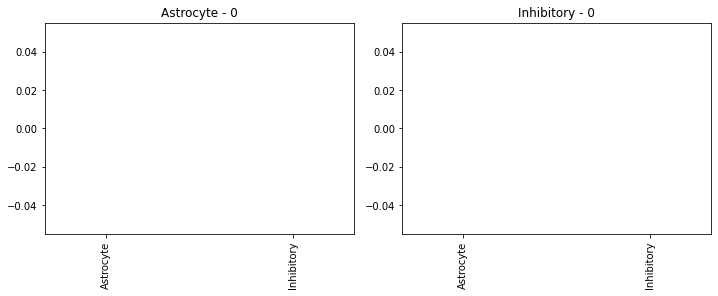

In [99]:
maxcellcount = len(count_misprediction[celltypes[0]].keys())
maxcellcount = 1

plt.rcParams['figure.figsize'] = [20, 15*maxcellcount]

j=0
for j in range(maxcellcount):
    for i, celltype in enumerate(celltypes):
        x = list(count_misprediction[celltype][j][2].keys())
        y = np.array(list(count_misprediction[celltype][j][2].values()))
        plt.subplot(4*maxcellcount, 4, j*16+i+1)
        bar = plt.bar(x, y, width=0.5, color='g')
        plt.xticks(rotation=90)
        # plt.ylim((0,100))
        plt.title(celltype + " - " + str(j))
        plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

In [100]:
celltype = 'Astrocyte'
np.array(list(count_misprediction[celltype][j][2].values()))

array([0, 0])

# Fraction to cellcount ratio

In [101]:
typeCountDf.head()

,Astrocyte,Inhibitory
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [102]:
df_fraction = df_prediction.divide(df_prediction.sum(axis=1), axis=0)
df_fraction['Cellcount'] = typeCountDf[celltypes[0]]
df_fraction.head()

,Astrocyte,Inhibitory,Cellcount
0,0.5,0.5,1
1,0.5,0.5,1
2,1.0,0.0,1
3,1.0,0.0,1
4,0.5,0.5,1


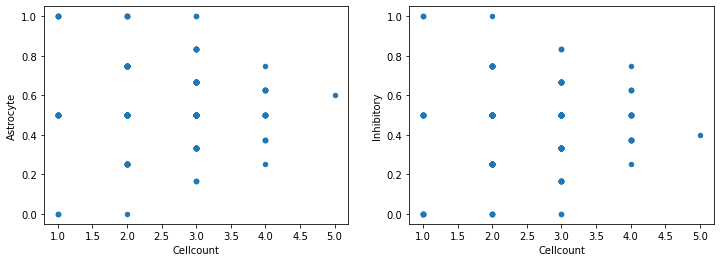

In [103]:
fix, axs = plt.subplots(1, len(celltypes), figsize=(12, 4))

for i, celltype in enumerate(celltypes):
    df_fraction.plot.scatter(x='Cellcount', y=celltype, ax=axs[i])

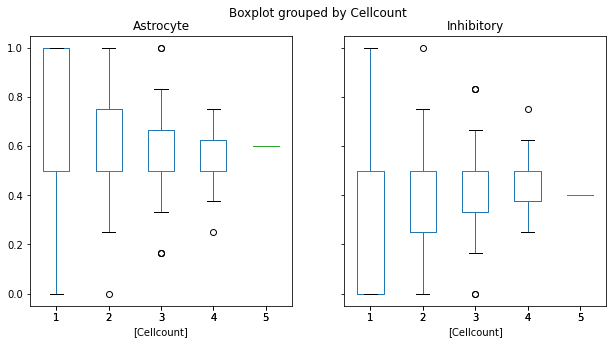

In [104]:
df_fraction.boxplot(by='Cellcount', grid=False);